In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

"""
REFERENCE
---------

https://www.kaggle.com/hsankesara/news-classification-using-han/notebook
https://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e

"""

Using TensorFlow backend.


'\nREFERENCE\n---------\n\nhttps://www.kaggle.com/hsankesara/news-classification-using-han/notebook\nhttps://medium.com/analytics-vidhya/hierarchical-attention-networks-d220318cf87e\n\n'

In [2]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [3]:
max_features=200000
max_senten_len=40
max_senten_num=6
embed_size=100
VALIDATION_SPLIT = 0.2

In [4]:
from sklearn.utils import shuffle

df = shuffle(pd.read_json('News_Category_Dataset_v2.json', lines=True)).reset_index()

In [5]:
df.head()

,index,authors,category,date,headline,link,short_description
0,33886,Jamie Feldman,STYLE,2017-02-20,Feast Your Eyes On This Bonkers Doughnut Dress...,https://www.huffingtonpost.com/entry/doughnut-...,"Do-nut lie, this dress is making you hungry."
1,123481,Andres Jauregui,CRIME,2014-05-06,"Wisconsin Boy, 3, Shoots Self In Head With Mom...",https://www.huffingtonpost.com/entry/wisconsin...,
2,137561,Megan Mayer,STYLE & BEAUTY,2013-12-03,Amanda Seyfried Has The Hair Of A Mythological...,https://www.huffingtonpost.com/entry/amanda-se...,It can attain that impossible state between wa...
3,13825,"Richard (RJ) Eskow, ContributorHost of 'The Ze...",POLITICS,2017-10-18,How To Profit From The Coming Trump Apocalypse,https://www.huffingtonpost.com/entry/how-to-pr...,Somebody ought to write a self-help book for R...
4,89695,"Kimberly Inskeep, ContributorPresident & Chief...",WOMEN,2015-05-29,The Third Option: More Than Both Having and Ea...,https://www.huffingtonpost.com/entry/the-third...,"When making a decision, it often feels like th..."


In [6]:
df.category.unique()

array(['STYLE', 'CRIME', 'STYLE & BEAUTY', 'POLITICS', 'WOMEN',
       'WELLNESS', 'ENTERTAINMENT', 'FOOD & DRINK', 'HOME & LIVING',
       'TRAVEL', 'DIVORCE', 'SCIENCE', 'BLACK VOICES', 'QUEER VOICES',
       'TECH', 'PARENTING', 'BUSINESS', 'COLLEGE', 'ARTS & CULTURE',
       'GREEN', 'SPORTS', 'WORLDPOST', 'HEALTHY LIVING', 'THE WORLDPOST',
       'PARENTS', 'WEIRD NEWS', 'COMEDY', 'GOOD NEWS', 'WORLD NEWS',
       'TASTE', 'RELIGION', 'CULTURE & ARTS', 'ARTS', 'WEDDINGS', 'MONEY',
       'IMPACT', 'MEDIA', 'EDUCATION', 'FIFTY', 'LATINO VOICES',
       'ENVIRONMENT'], dtype=object)

In [7]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [8]:
df['text'] = df['headline'] +'. ' +df['short_description']


In [9]:
df.head()


,index,authors,category,date,headline,link,short_description,text
0,33886,Jamie Feldman,STYLE,2017-02-20,Feast Your Eyes On This Bonkers Doughnut Dress...,https://www.huffingtonpost.com/entry/doughnut-...,"Do-nut lie, this dress is making you hungry.",Feast Your Eyes On This Bonkers Doughnut Dress...
1,123481,Andres Jauregui,CRIME,2014-05-06,"Wisconsin Boy, 3, Shoots Self In Head With Mom...",https://www.huffingtonpost.com/entry/wisconsin...,,"Wisconsin Boy, 3, Shoots Self In Head With Mom..."
2,137561,Megan Mayer,STYLE & BEAUTY,2013-12-03,Amanda Seyfried Has The Hair Of A Mythological...,https://www.huffingtonpost.com/entry/amanda-se...,It can attain that impossible state between wa...,Amanda Seyfried Has The Hair Of A Mythological...
3,13825,"Richard (RJ) Eskow, ContributorHost of 'The Ze...",POLITICS,2017-10-18,How To Profit From The Coming Trump Apocalypse,https://www.huffingtonpost.com/entry/how-to-pr...,Somebody ought to write a self-help book for R...,How To Profit From The Coming Trump Apocalypse...
4,89695,"Kimberly Inskeep, ContributorPresident & Chief...",WOMEN,2015-05-29,The Third Option: More Than Both Having and Ea...,https://www.huffingtonpost.com/entry/the-third...,"When making a decision, it often feels like th...",The Third Option: More Than Both Having and Ea...


In [10]:
df = df[['text', 'category']]


In [11]:
df.head()

,text,category
0,Feast Your Eyes On This Bonkers Doughnut Dress...,STYLE
1,"Wisconsin Boy, 3, Shoots Self In Head With Mom...",CRIME
2,Amanda Seyfried Has The Hair Of A Mythological...,STYLE & BEAUTY
3,How To Profit From The Coming Trump Apocalypse...,POLITICS
4,The Third Option: More Than Both Having and Ea...,WOMEN


In [12]:
categories = df['category']
text = df['text']

In [13]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 40
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       4528
BUSINESS           5937
COLLEGE            1144
COMEDY             5175
CRIME              3405
CULTURE & ARTS     1030
DIVORCE            3426
EDUCATION          1004
ENTERTAINMENT     16058
ENVIRONMENT        1323
FIFTY              1401
FOOD & DRINK       6226
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
HOME & LIVING      4195
IMPACT             3459
LATINO VOICES      1129
MEDIA              2815
MONEY              1707
PARENTING          8677
PARENTS            3955
POLITICS          32739
QUEER VOICES       6314
RELIGION           2556
SCIENCE            2178
SPORTS             4884
STYLE              2254
STYLE & BEAUTY     9649
TASTE              2096
TECH               2082
TRAVEL             9887
WEDDINGS           3651
WEIRD NEWS         2670
WELLNESS          17827
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int

In [14]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [ ]:
import re

# remove everything that starts with http 
data = df[['name', 'bodytxt', 'name_bodytxt']].applymap(lambda line: re.sub('http[s]?://\S+', '', line))

# remove everything within a () 
data = data[['name', 'bodytxt', 'name_bodytxt']].applymap(lambda line: re.sub(r" ?\([^)]+\)", " ",  line))

# remove everything within a []
data = data[['name', 'bodytxt', 'name_bodytxt']].applymap(lambda line: re.sub(r'\[[^()]*\]', " ",  line))

cleaned_data = data['name_bodytxt']
# cleaned_data = data['name_bodytxt'].apply(''.join).str.replace('[^A-Za-z\s!.?]+', '')

def _(sentence):
    a = ['MPN', "BSWAR", "EAN", "xxcm", "\r", "\n"] #, "Package Dimensions", "Product Dimensions", "mg", "mL", "\xa0"]
    for val in a:
        if val in sentence:
            sentence = sentence.replace(val, "")
    
    # remove words that has only a character 
    sentence = re.sub(r'\b\w{1,1}\b', '', sentence)
    
    # Typically, bodytxt has the form title, followed by product description. However, they are not differentiated into different sentences
    sentence = sentence.replace("Product Description", ". ")
    sentence = sentence.replace("\xa0", " ")
    sentence = sentence.replace("-", " ")

    return sentence

processed_data = list(map(_, cleaned_data.values))


In [ ]:
paras = []
labels = []
texts = []

sent_lens = []
sent_nums = []

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import LancasterStemmer

lancaster=LancasterStemmer()

m = len(processed_data)

labels = []

for idx in range(m):
    # print("{}/{}".format(idx, m))
    text = processed_data[idx]
    
    # texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    

    for i, sentence in enumerate(sentences):

        # remove everything before a \t
        # Because everything before a \t\t\t\t might be meaningless 
        cond = sentence.find("\t")
        if cond > 0:
            sentences[i] = sentence[cond:]

        # remove evrything after : 
        # because typically after a colon, you will see things such as Brand:, Product Dimensions: , etc 
        cond = sentence.find(":")
        if cond > 0:
            sentences[i] = sentence[:cond]

        sentences[i] = sentence.replace("\t", "")  
        
        # lower case 
        sentences[i] = sentences[i].lower()
        
        
    # -------------------------------------------------------
    for i, sent in enumerate(sentences):
        
        # remove all non-alphanumeric characters 
        sent = re.sub('[^A-Za-z\s]+', '', sent)
        sentences[i] = sent
        
    # -------------------------------------------------------
    
    
    
    # -------------------------------------------------------
    # remove any duplicate sentences
    for i, sent in enumerate(sentences):
        a = sent.split(" ")
        
        # removal of unncessary space and single word charcter 
        a =[val for val in a if len(val)>1]
        
        # stopword removal 
        # a = [k for k in a if not k in stop_words]
        
        """
        # stemming
        for c, word in enumerate(a):
            a[c] = lancaster.stem(word)
        """
        
        
        
        sentences[i] = " ".join(a)
        
    # sentences = list(set(sentences)) --> lose temporal information as set has no sequence
    tmp = []
    for s in sentences:
        
        """
        a = [] 
        
        for val in s.split(" "):
            if val not in absent_word:
                a.append(val)
        s = " ".join(a)
        """
        
        if s not in tmp:
            tmp.append(s)
            
    sentences = tmp 
    # -------------------------------------------------------
    
    
    # -------------------------------------------------------
    new_sentences = []
    for sent in sentences:
        # remove sentences with less than or equal to 1 word 
        if len(text_to_word_sequence(sent)) > 1:
            new_sentences.append(sent) 
        else:
            # print(sent)
            pass
    sentences = new_sentences
    
    sentences = sorted(sentences, key = lambda x: len(x.split()), reverse = True)
        
    
    # skip the datapoint if len(sentences) == 0 
    if len(sentences) == 0:
        print("skipped: {}".format(idx))
        continue
    
    
        
    # REQUIRED to fit Tokenizer
    texts.append("".join(sentences))
    

        
    sent_nums.append(len(sentences)) # num of sentences in the datapoint 
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
        
    # our training data 
    paras.append(sentences)
    
    labels.append(df['category_number'].values[idx])


In [65]:
df.iloc[0]['text']

'Feast Your Eyes On This Bonkers Doughnut Dress At Fashion Week. Do-nut lie, this dress is making you hungry.'

In [15]:
paras = []
labels = []
texts = []

sent_lens = []
sent_nums = []
for idx in range(df.text.shape[0]):
    text = clean_str(df.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)
    

In [66]:
clean_str(df.iloc[0]['text'])

'feast your eyes on this bonkers doughnut dress at fashion week. do-nut lie, this dress is making you hungry.'

In [16]:
# length of all the sentences, i.e sentence length
len(sent_lens)

479927

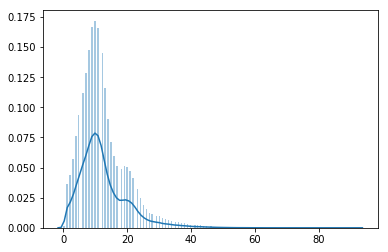

In [17]:
sns.distplot(sent_lens, bins=200)
plt.show()

In [18]:
# how many sentences in each datapoint, where len(df) == len(sent_nums)
len(sent_nums)

200853

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/scipy/stats/stats.py:1857: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


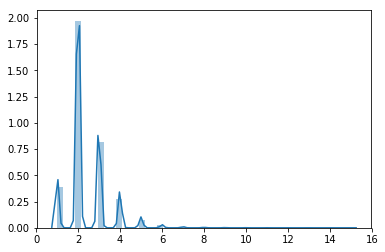

In [19]:
sns.distplot(sent_nums)
plt.show()

In [20]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass
                

at johansson
but if
— david
the hamilton creator
gratisography
bob mcdonnell
and its


In [21]:
texts[0]

'feast your eyes on this bonkers doughnut dress at fashion week. do-nut lie, this dress is making you hungry.'

In [22]:
df.iloc[0].values

array(['Feast Your Eyes On This Bonkers Doughnut Dress At Fashion Week. Do-nut lie, this dress is making you hungry.',
       'STYLE'], dtype=object)

In [23]:
data[0]

array([[ 4664,    19,   891,    11,    17, 10583, 12949,   437,    22,
          238,    98,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [   52,  8798,  2241,    17,   437,     8,   223,    12,  3476,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    0,     0,     0,     0,  

In [24]:
data.shape


(200853, 6, 40)

In [25]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 100266 unique tokens.


In [26]:
labels = pd.get_dummies(categories)
labels.head()

,ARTS,ARTS & CULTURE,BLACK VOICES,BUSINESS,COLLEGE,COMEDY,CRIME,CULTURE & ARTS,DIVORCE,EDUCATION,...,STYLE & BEAUTY,TASTE,TECH,TRAVEL,WEDDINGS,WEIRD NEWS,WELLNESS,WOMEN,WORLD NEWS,WORLDPOST
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [27]:
print('Shape of data tensor:', data.shape) # i.e. 200853 data points, 6 sentences, 40 words 
print('Shape of labels tensor:', labels.shape) # 40 different classes, one hot encoded 

Shape of data tensor: (200853, 6, 40)
Shape of labels tensor: (200853, 40)


In [28]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [29]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [30]:
GLOVE_DIR = "glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [31]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 27655 which is 27.58 % of total words


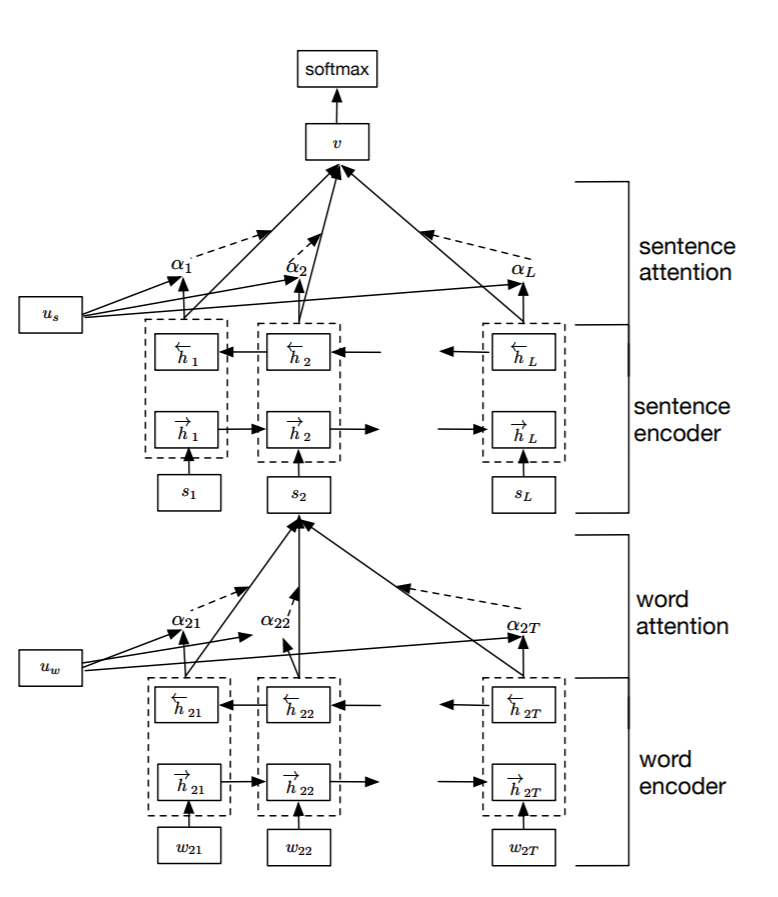

In [33]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
#word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_lstm)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
#sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_lstm))
preds = Dense(40, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])



In [34]:
import tensorflow as tf 
import pydotplus

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [35]:
from keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint('HAN_test_best_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 
es = EarlyStopping(monitor='val_loss', mode='min', patience = 4, verbose=1)

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6, 40)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 6, 300)            10418500  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 6, 300)            541200    
_________________________________________________________________
attention_with_context_4 (At (None, 300)               90600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                12040     
Total params: 11,062,340
Trainable params: 1,035,640
Non-trainable params: 10,026,700
________________________________________________________

In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=512, callbacks=[es])

Train on 160683 samples, validate on 40170 samples
Epoch 1/50
160683/160683 [==============================] - 143s 890us/step - loss: 2.0678 - acc: 0.4552 - val_loss: 1.5669 - val_acc: 0.5654
Epoch 2/50
160683/160683 [==============================] - 122s 757us/step - loss: 1.5025 - acc: 0.5828 - val_loss: 1.3995 - val_acc: 0.6046
Epoch 3/50
160683/160683 [==============================] - 120s 749us/step - loss: 1.3782 - acc: 0.6112 - val_loss: 1.3339 - val_acc: 0.6175
Epoch 4/50
160683/160683 [==============================] - 121s 754us/step - loss: 1.2995 - acc: 0.6294 - val_loss: 1.2943 - val_acc: 0.6277
Epoch 5/50
160683/160683 [==============================] - 122s 759us/step - loss: 1.2373 - acc: 0.6436 - val_loss: 1.2645 - val_acc: 0.6348
Epoch 6/50
160683/160683 [==============================] - 120s 749us/step - loss: 1.1843 - acc: 0.6574 - val_loss: 1.2540 - val_acc: 0.6379
Epoch 7/50
160683/160683 [==============================] - 122s 758us/step - loss: 1.1379 - acc:

In [38]:
print(history.history.keys())

dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


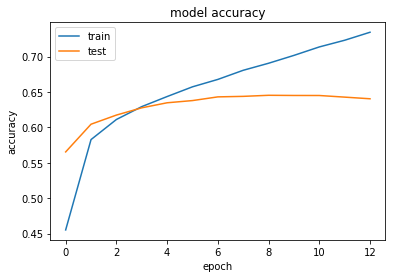

In [39]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

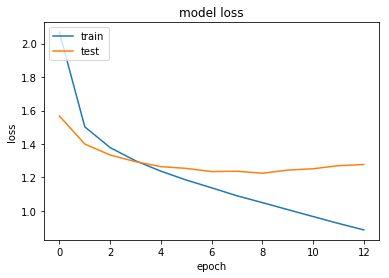

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('test_HAN.h5')

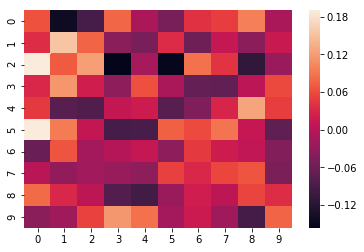

In [61]:
import seaborn as sns

sns.heatmap(model.layers[3].get_weights()[0][:10, :10])

In [51]:
from keras import backend as K
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
